In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics

In [2]:
DIR = "C:/Users/Admin/Downloads/archive (1)/kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

In [3]:
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []

patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:11<00:00, 10.16it/s]


Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


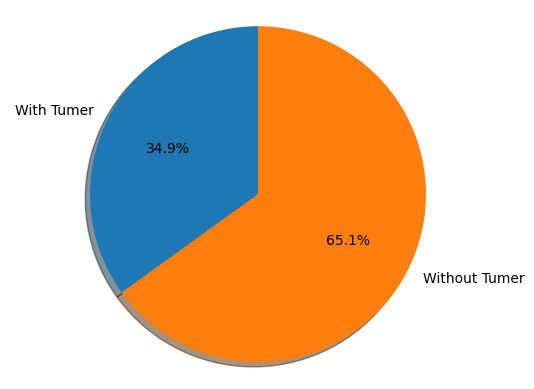

In [4]:
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)


print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [5]:
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)

In [6]:
with_tumer_val_images = 300
without_tumer_val_images = 600

with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)


print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [7]:
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [8]:
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

In [9]:
def adjust_data(img,mask):
    img = img / 255
#     imt = 1 - img
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [10]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

In [11]:
smooth=1

def dice_coef(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)
    And = keras.backend.sum(y_truef*y_predf)
    return((2* And + smooth) / (keras.backend.sum(y_truef) + keras.backend.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.backend.sum(y_true * y_pred)
    sum_ = keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)

    return - iou(y_true, y_pred)

In [12]:
from keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [13]:
keras.backend.clear_session()

In [14]:
inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
# c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
# c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
# c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
# c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
# c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)

u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
# c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
# c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)

u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
# c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
# c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv1_2 (Conv2D)            (None, 256, 256, 32)         9248      ['conv1_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv1_2[0][0]']             
 Normalization)                                                                               

 concatenate_1 (Concatenate  (None, 64, 64, 256)          0         ['conv7_1[0][0]',             
 )                                                                   'activation_2[0][0]']        
                                                                                                  
 conv7_2 (Conv2D)            (None, 64, 64, 128)          295040    ['concatenate_1[0][0]']       
                                                                                                  
 conv7_3 (Conv2D)            (None, 64, 64, 128)          147584    ['conv7_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 64, 64, 128)          512       ['conv7_3[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 activatio

In [15]:
EPOCHS = 1
learning_rate = 1e-1
decay_rate = learning_rate / 10

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.05, 
        epsilon=0.1), 
    loss=focal_tversky,
    metrics=[tversky])

model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
#early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[model_checkpoint])

94/94 [==============================] - ETA: 0s - loss: 0.9354 - tversky: 0.0849  
Epoch 1: val_loss improved from inf to 0.97271, saving model to unet_brain_mri_seg.hdf5


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3002: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 6821s 72s/step - loss: 0.9354 - tversky: 0.0849 - val_loss: 0.9727 - val_tversky: 0.0362


In [24]:
# model.compile(
#     optimizer=keras.optimizers.Adam(
#         learning_rate=0.05, 
#         epsilon=0.1), 
#     loss=focal_tversky,
#     metrics=[tversky])

# model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
# early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

# history = model.fit(
#     train_gen, 
#     validation_data=val_gen,
#     epochs=EPOCHS,
#     callbacks=[model_checkpoint])

In [25]:
# model.compile(
#     optimizer=keras.optimizers.Adam(
#         learning_rate=0.05, 
#         epsilon=0.1), 
#     loss=focal_tversky,
#     metrics=[tversky])

# model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
# early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

# history = model.fit(
#     train_gen, 
#     validation_data=val_gen,
#     epochs=EPOCHS,
#     callbacks=[model_checkpoint])

In [17]:
a = history.history

list_trainloss = a['loss']
list_testloss = a['val_loss']
list_traindice = a['tversky']
list_testdice = a['val_tversky']

[0.9727117419242859]
[0.9354408979415894]
[0.0849384218454361]
[0.03619316592812538]


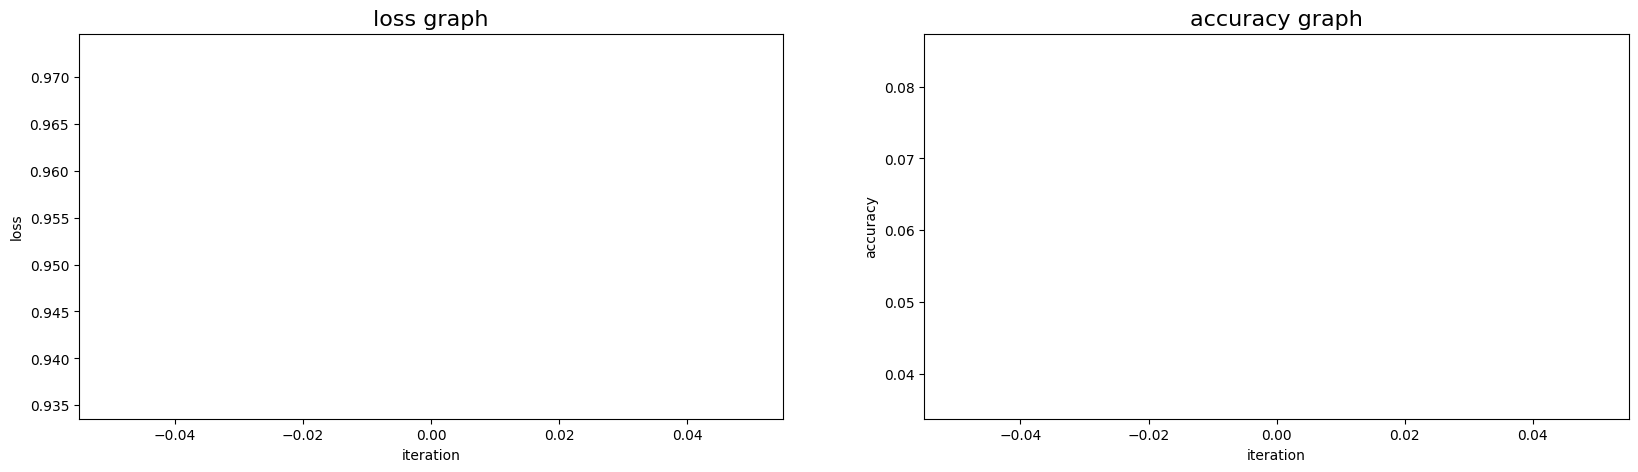

In [26]:
plt.figure(figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.set_title('loss graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
print(list_testloss)
print(list_trainloss)
ax = plt.subplot(1, 2, 2)
ax.set_title('accuracy graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(list_traindice, 'r-')
print(list_traindice)
plt.plot(list_testdice, 'b-')
print(list_testdice)

plt.show()

In [20]:
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

In [21]:
model = keras.models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'focal_tversky': focal_tversky, 'tversky': tversky})
# model = keras.models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
preds = model.predict(x / 255)

1/1 [==============================] - 7s 7s/step


In [22]:
preds_t = (preds > 0.5).astype(np.uint8)
print(np.amax(preds))
print(np.amax(preds_t))
print(preds.shape)

print(np.unique(preds_t, return_counts=True))

0.5743834
1
(15, 256, 256, 1)
(array([0, 1], dtype=uint8), array([978880,   4160], dtype=int64))


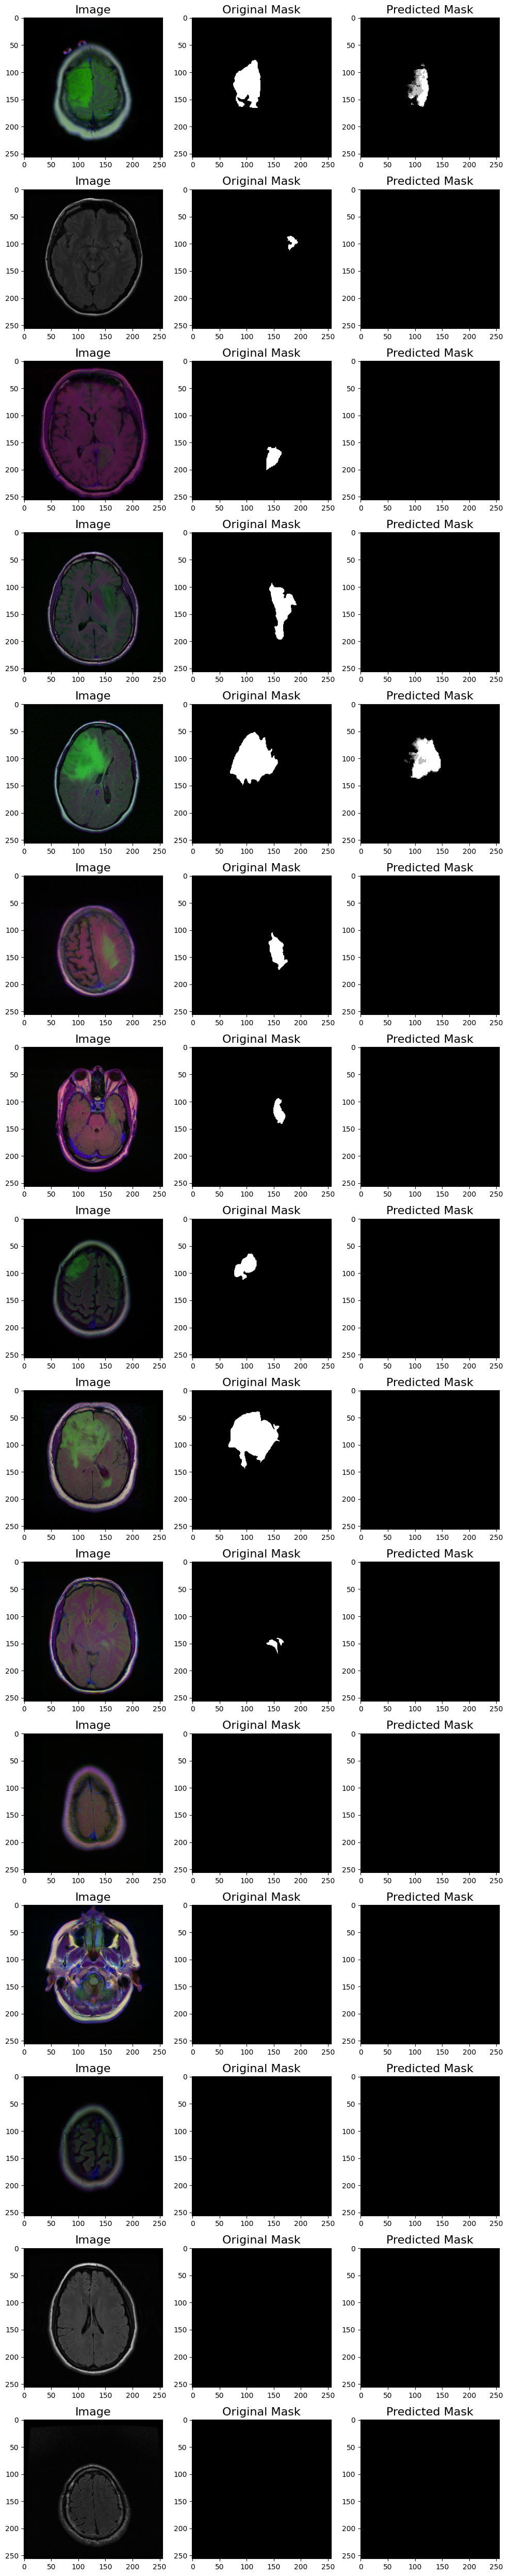

In [23]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')
        
plt.tight_layout()
plt.show()

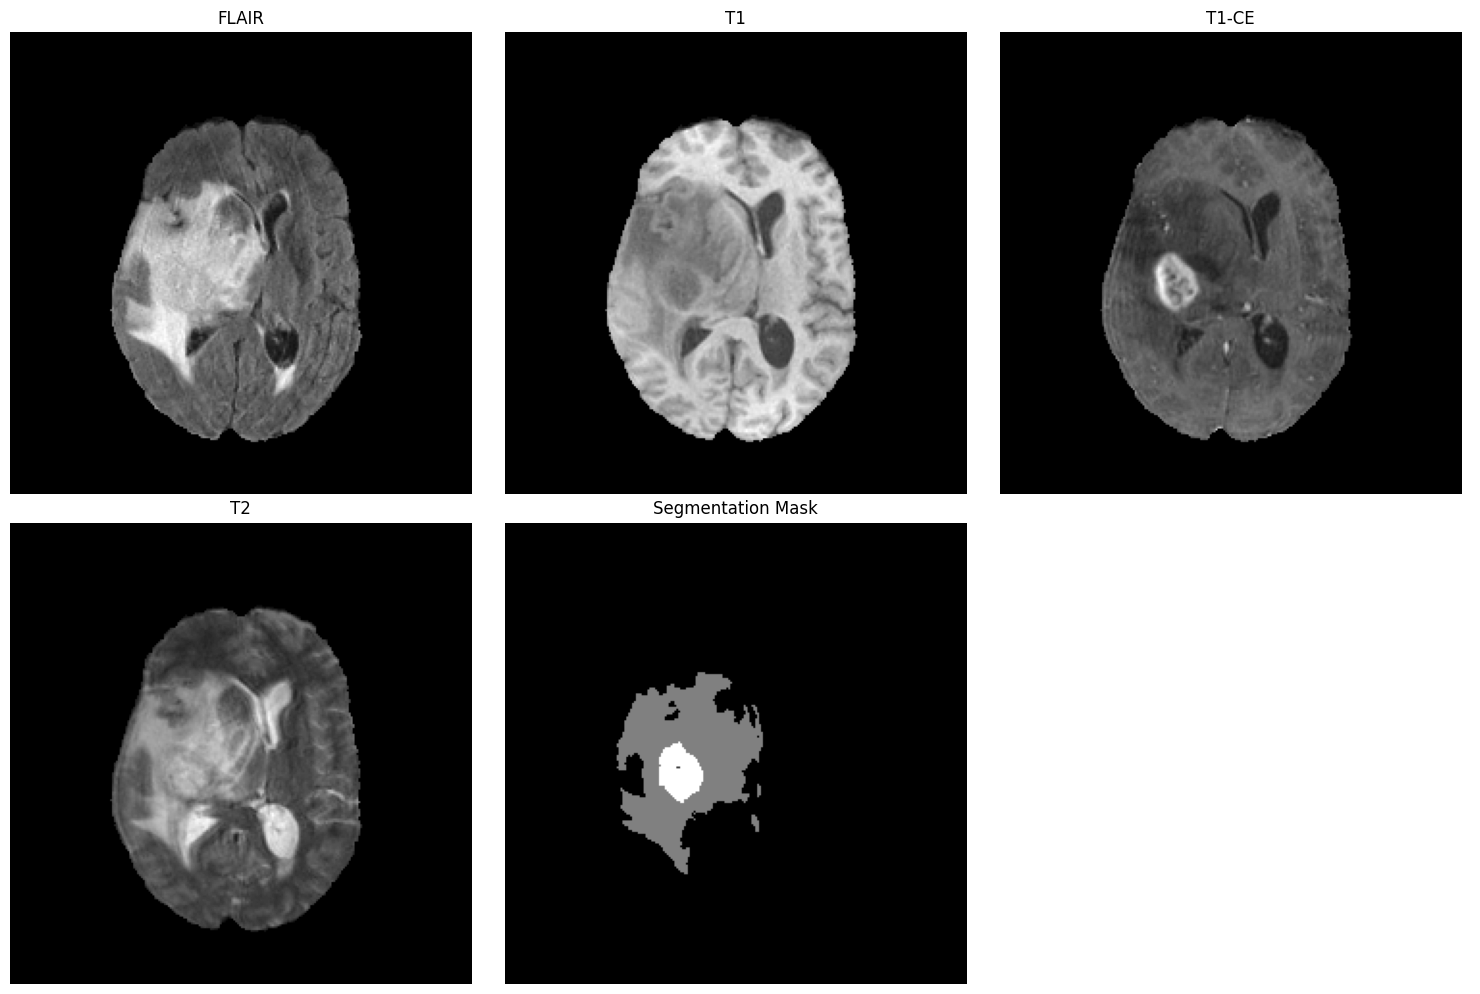

In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Define the file paths for each modality
flair_path = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
t1_path = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
t1ce_path = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
t2_path = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'

seg_path = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'

# Load the images using SimpleITK
flair_img = sitk.ReadImage(flair_path)
t1_img = sitk.ReadImage(t1_path)
t1ce_img = sitk.ReadImage(t1ce_path)
t2_img = sitk.ReadImage(t2_path)
seg_img = sitk.ReadImage(seg_path)

# Convert SimpleITK images to numpy arrays for visualization
flair_array = sitk.GetArrayFromImage(flair_img)
t1_array = sitk.GetArrayFromImage(t1_img)
t1ce_array = sitk.GetArrayFromImage(t1ce_img)
t2_array = sitk.GetArrayFromImage(t2_img)
seg_array = sitk.GetArrayFromImage(seg_img)

# Display sample images from each modality along with the segmentation mask
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(flair_array[flair_array.shape[0] // 2, :, :], cmap='gray')
axes[0, 0].set_title('FLAIR')

axes[0, 1].imshow(t1_array[t1_array.shape[0] // 2, :, :], cmap='gray')
axes[0, 1].set_title('T1')

axes[0, 2].imshow(t1ce_array[t1ce_array.shape[0] // 2, :, :], cmap='gray')
axes[0, 2].set_title('T1-CE')

axes[1, 0].imshow(t2_array[t2_array.shape[0] // 2, :, :], cmap='gray')
axes[1, 0].set_title('T2')

axes[1, 1].imshow(seg_array[seg_array.shape[0] // 2, :, :], cmap='gray')
axes[1, 1].set_title('Segmentation Mask')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()


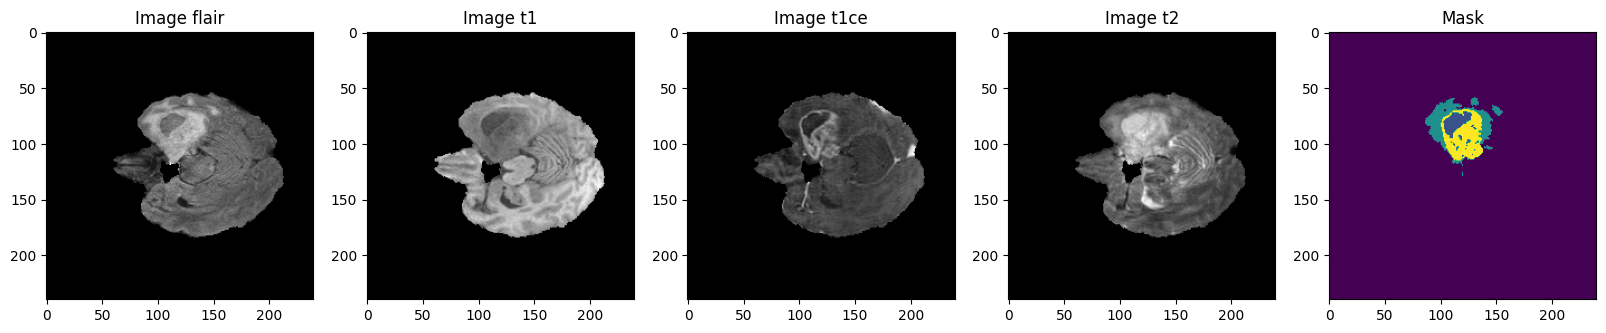

In [10]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
TRAIN_DATASET_PATH = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25

ax1.imshow(test_image_flair[:, :, test_image_flair.shape[2] // 2 - slice_w], cmap='gray')
ax1.set_title('Image flair')

ax2.imshow(test_image_t1[:, :, test_image_t1.shape[2] // 2 - slice_w], cmap='gray')
ax2.set_title('Image t1')

ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[2] // 2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')

ax4.imshow(test_image_t2[:, :, test_image_t2.shape[2] // 2 - slice_w], cmap='gray')
ax4.set_title('Image t2')

ax5.imshow(test_mask[:, :, test_mask.shape[2] // 2 - slice_w])
ax5.set_title('Mask')

plt.show()


In [154]:
import nilearn
import nibabel as nib
import nilearn.plotting as nlplt
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import pandas as pd

# Segmentation Models
# import segmentation_models as sm

# Keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
# 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [155]:
from keras.utils import plot_model

In [156]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
TRAINING_DATASET = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*'

# TRAINING_DATASET = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*"

IMAGE_DIR = glob.glob(TRAINING_DATASET)
# Remove CSV files from IMAGE_DIR list
CSV_LIST = glob.glob(TRAINING_DATASET + 'csv')
for i in CSV_LIST:
    if i in IMAGE_DIR:
        IMAGE_DIR.remove(i)

# Remove the specific directory from IMAGE_DIR list if it exists
specific_directory = TRAINING_DATASET.replace("*", "") + 'BraTS20_Training_355'
if specific_directory in IMAGE_DIR:
    IMAGE_DIR.remove(specific_directory)

# Limit the IMAGE_DIR list to the first 100 elements
IMAGE_DIR = IMAGE_DIR[:100]


TRAIN_LIST, VAL_LIST = train_test_split(IMAGE_DIR, test_size=0.2)
TRAIN_LIST, TEST_LIST = train_test_split(TRAIN_LIST, test_size=0.3)

VIEW_IMG_IDX = random.randint(0, len(TRAIN_LIST) - 1)
LIST_DATA = sorted(glob.glob(TRAIN_LIST[VIEW_IMG_IDX] + '/*'))
VIEW_IMAGE = {
    'flair': nib.load(LIST_DATA[0]).get_fdata(),
    't1': nib.load(LIST_DATA[2]).get_fdata(),
    't1ce': nib.load(LIST_DATA[3]).get_fdata(),
    't2': nib.load(LIST_DATA[4]).get_fdata(),
    'mask': nib.load(LIST_DATA[1]).get_fdata()
}


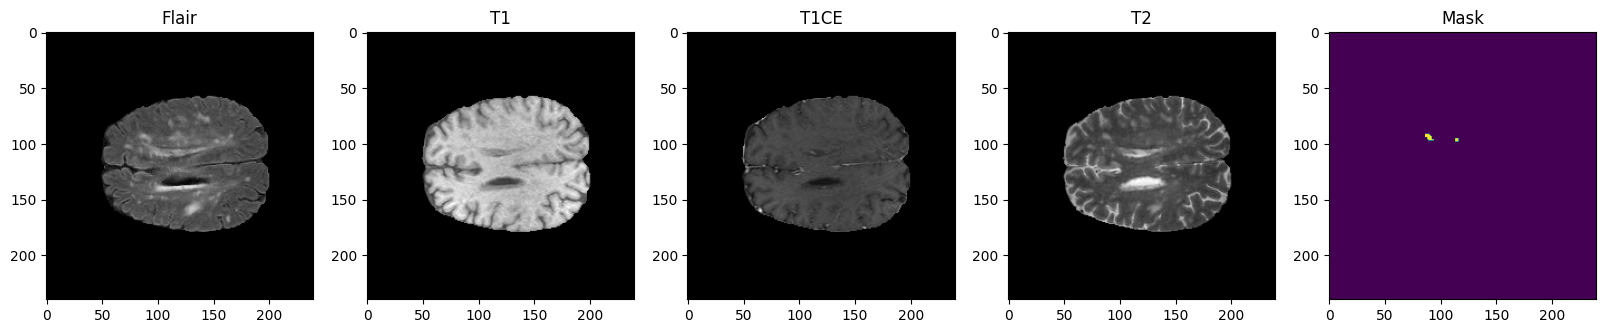

In [157]:
def analyse_initial_data():
    fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(1, 5, figsize=(20, 10))
    slice_w = 25
    axis1.imshow(VIEW_IMAGE['flair'][:, :,
               VIEW_IMAGE['flair'].shape[0]//2 - slice_w], cmap='gray')
    axis1.set_title('Flair')
    axis2.imshow(
        VIEW_IMAGE['t1'][:, :, VIEW_IMAGE['t1'].shape[0]//2 - slice_w], cmap='gray')
    axis2.set_title('T1')
    axis3.imshow(
        VIEW_IMAGE['t1ce'][:, :, VIEW_IMAGE['t1ce'].shape[0]//2 - slice_w], cmap='gray')
    axis3.set_title('T1CE')
    axis4.imshow(
        VIEW_IMAGE['t2'][:, :, VIEW_IMAGE['t2'].shape[0]//2 - slice_w], cmap='gray')
    axis4.set_title('T2')
    axis5.imshow(VIEW_IMAGE['mask']
               [:, :, VIEW_IMAGE['mask'].shape[0]//2 - slice_w])
    axis5.set_title('Mask')


analyse_initial_data()

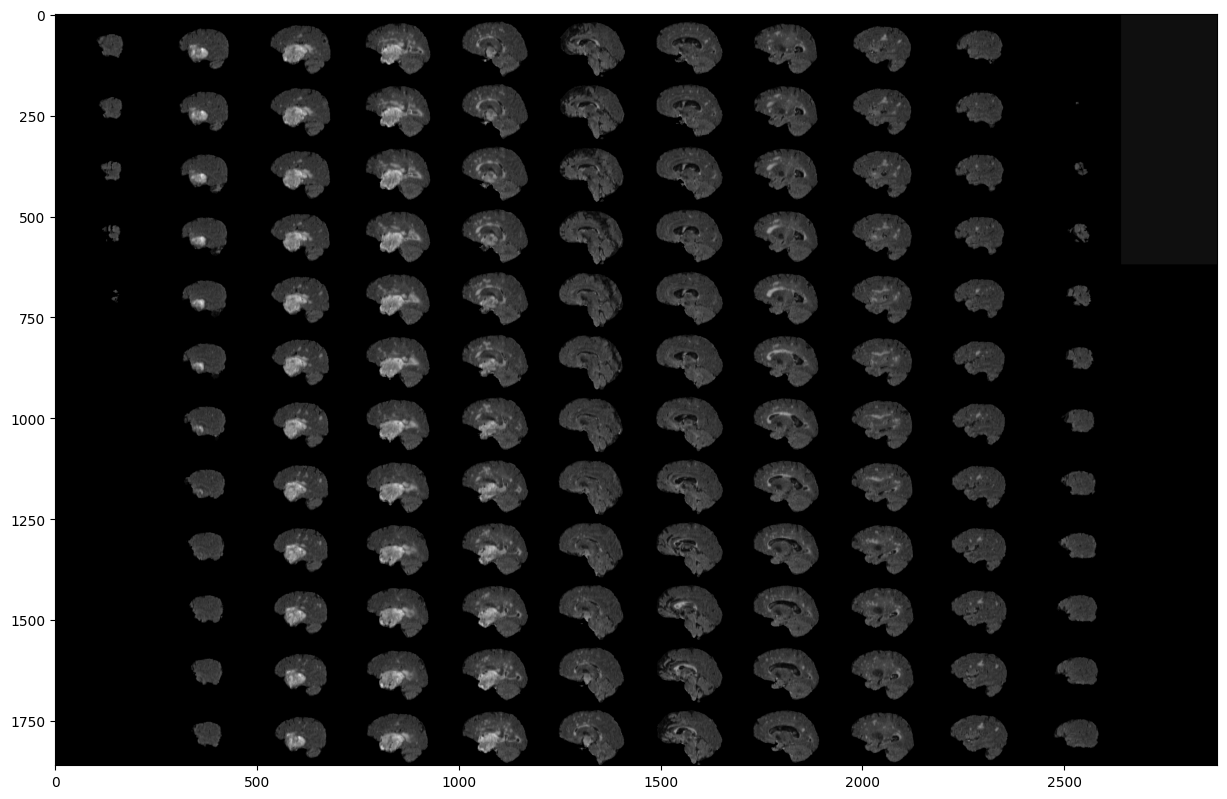

In [158]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['flair'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

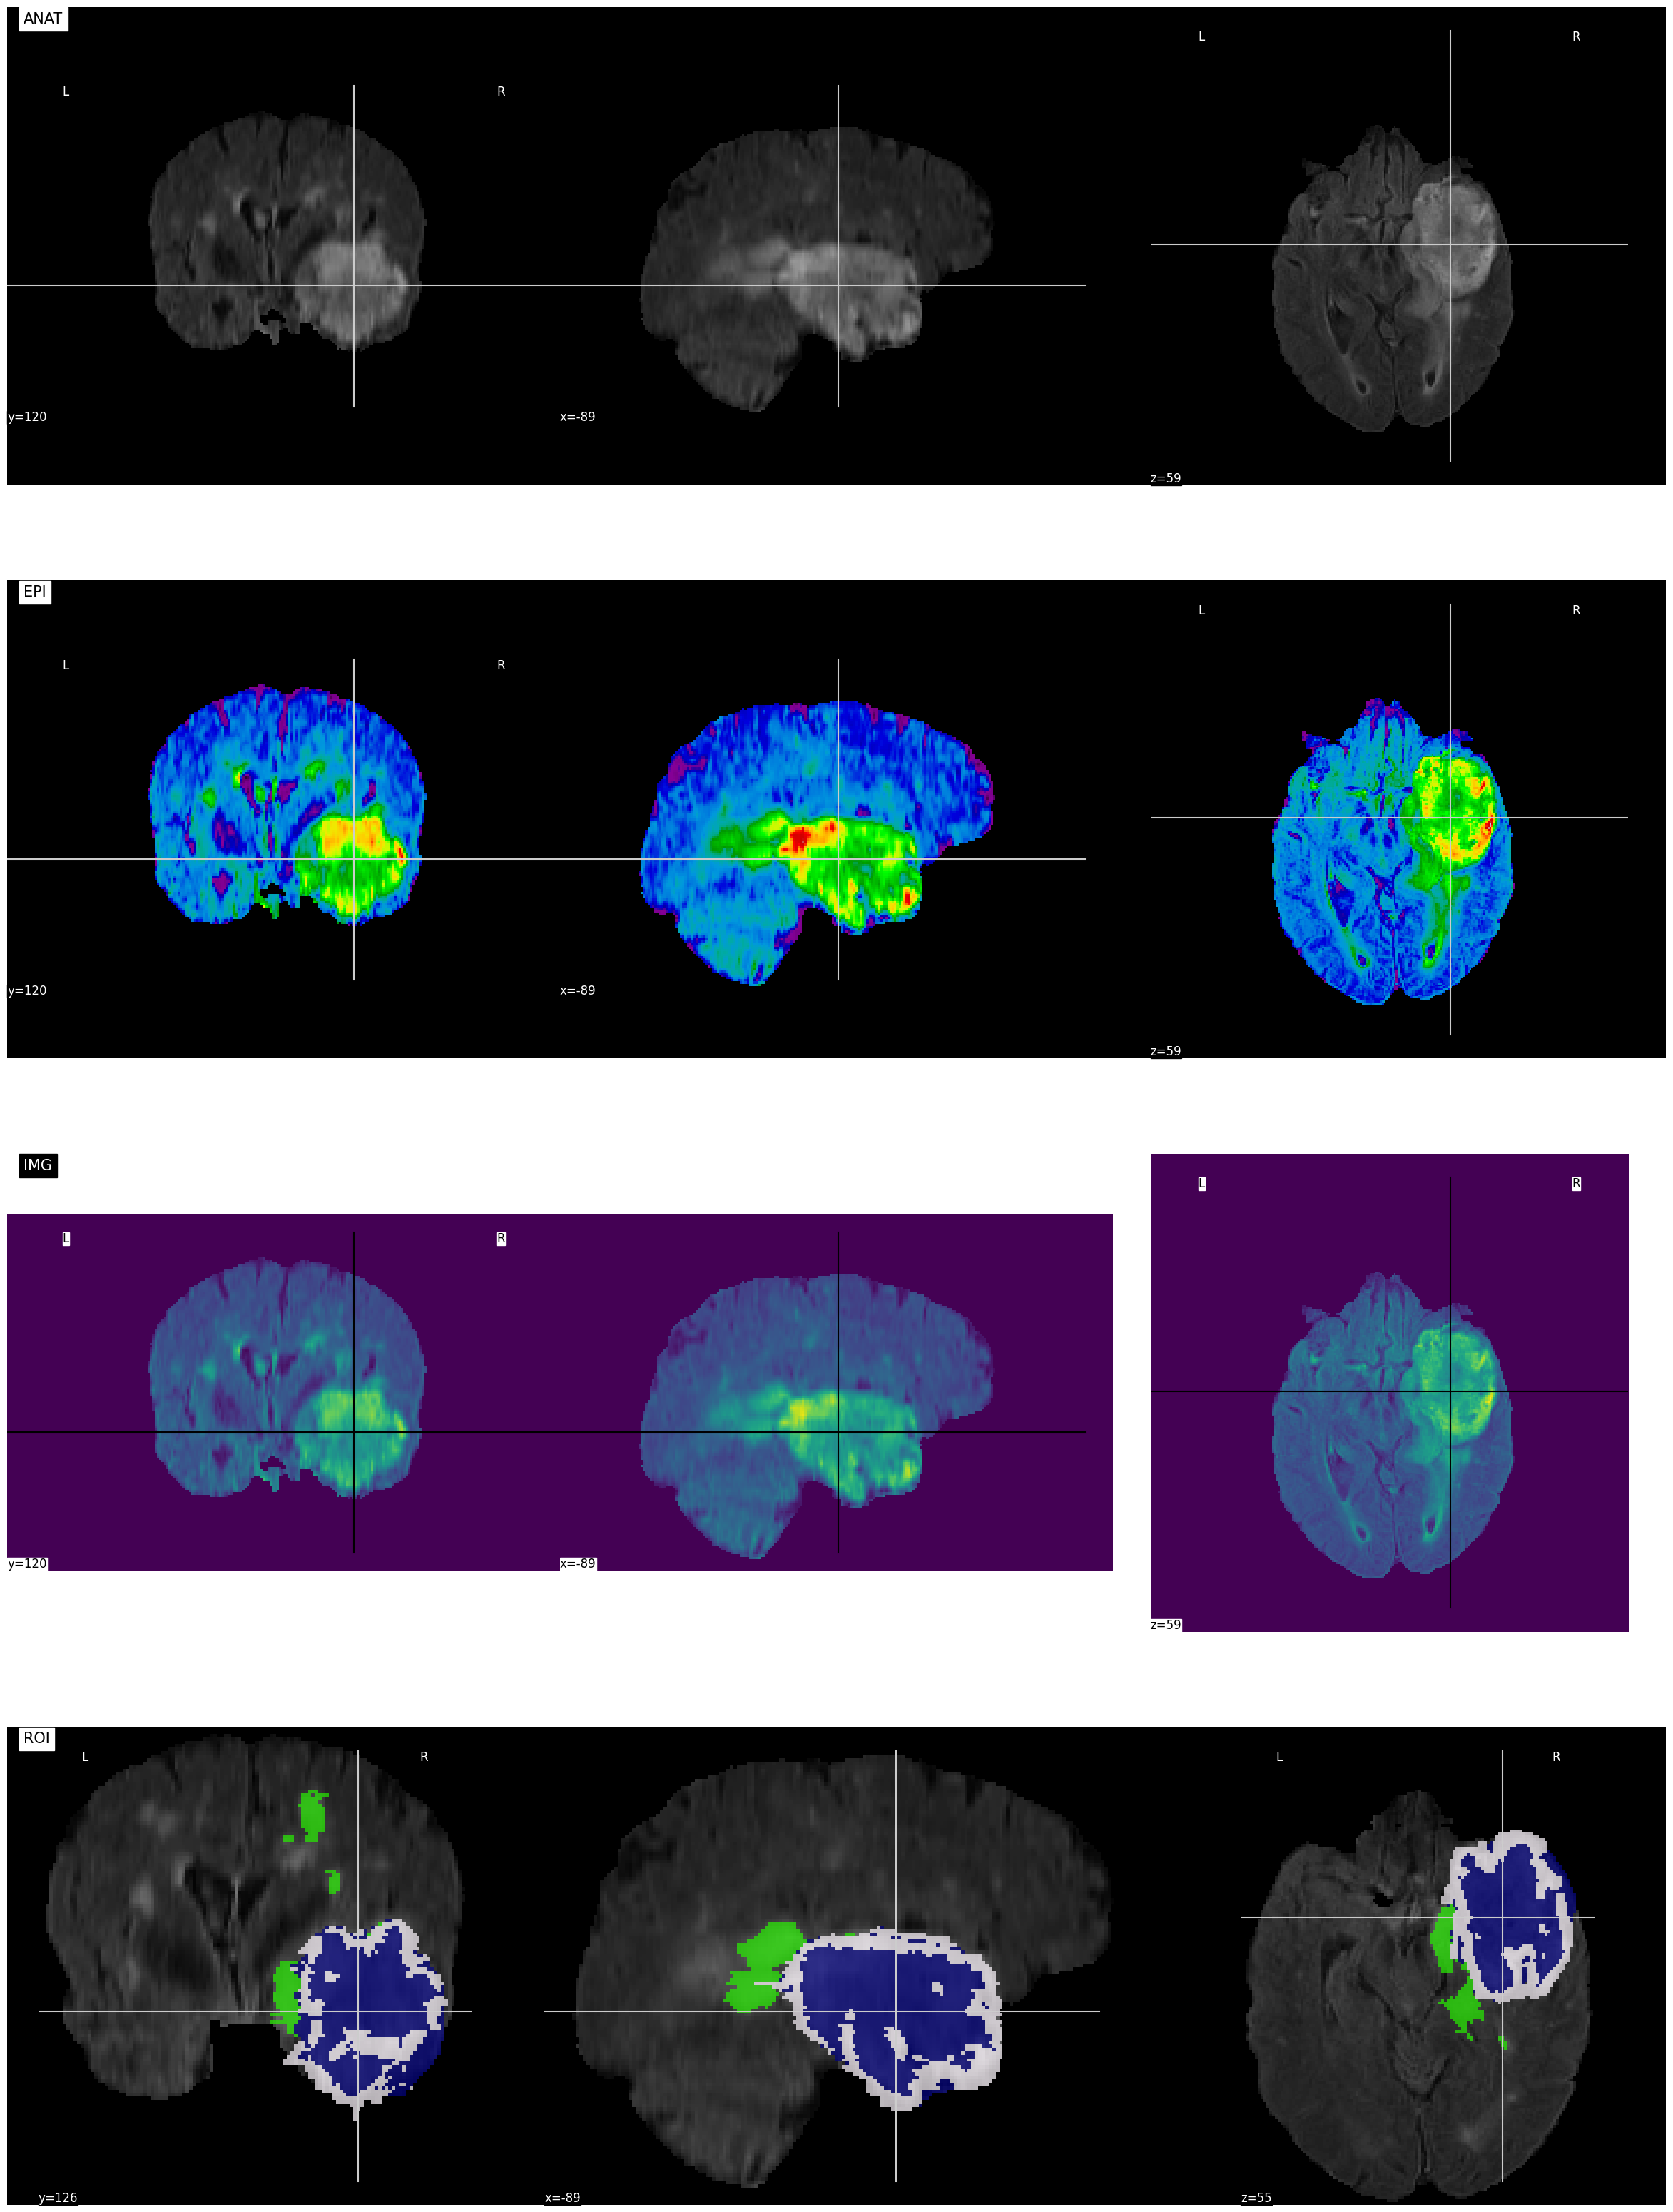

In [159]:
def show_mri_diagram():
    image = nilearn.image.load_img(LIST_DATA[0])
    mask = nilearn.image.load_img(LIST_DATA[1])
    fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
    nlplt.plot_anat(image, title='ANAT', axes=axes[0])
    nlplt.plot_epi(image, title='EPI', axes=axes[1])
    nlplt.plot_img(image, title='IMG', axes=axes[2])
    nlplt.plot_roi(mask, title='ROI', bg_img=image, axes=axes[3])
    plt.show()


show_mri_diagram()

In [164]:
from sklearn.model_selection import train_test_split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(image, mask, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

In [165]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [168]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(91, 128, 128)
(11, 128, 128)
(26, 128, 128)


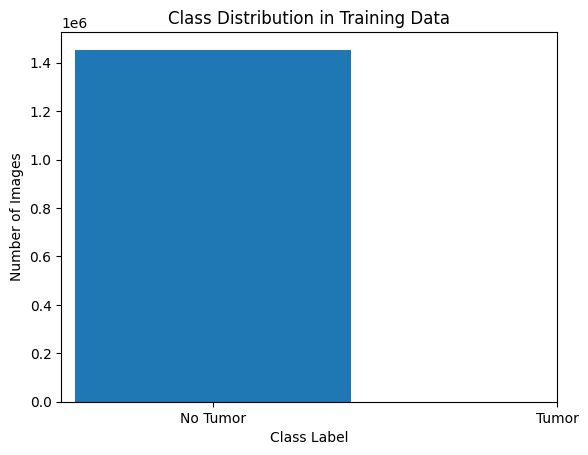

In [177]:
import matplotlib.pyplot as plt

# Flatten y_train
y_train_flat = y_train.flatten()

# Plot the histogram
plt.hist(y_train_flat, bins=[0, 1], align='left', rwidth=0.8)  # Bins for tumor (1) and no tumor (0)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.show()


In [178]:
from tensorflow import keras

model = keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

In [179]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [180]:
model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Epoch 1/2


ValueError: in user code:

    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1080, in train_step
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128)


In [138]:
from tensorflow.keras.models import Sequential

In [141]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
SLICES_VOL = 100
VOL_START = 22
IMG_SIZE = 128
class DataGenerator(Sequential):
    def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*SLICES_VOL,
                     *self.dimensions, self.n_channels))
        y = np.zeros((self.batch_size*SLICES_VOL, 240, 240))
        Y = np.zeros((self.batch_size*SLICES_VOL, *self.dimensions, 4))
        for c, i in enumerate(Batch_ids):
            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_flair.nii'
            flair = nib.load(data_path).get_fdata()
            flair = scaler.fit_transform(
                flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_t1ce.nii'
            ce = nib.load(data_path).get_fdata()
            ce = scaler.fit_transform(
                ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_seg.nii'
            seg = nib.load(data_path).get_fdata()

            for j in range(SLICES_VOL):
                X[j + SLICES_VOL*c, :, :,
                    0] = cv2.resize(flair[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(ce[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                y[j + SLICES_VOL*c] = seg[:, :, j+VOL_START]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


training_generator = DataGenerator(TRAIN_LIST)
val_generator = DataGenerator(VAL_LIST)
test_generator = DataGenerator(TEST_LIST)


In [142]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [143]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
 
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)
 
    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)
 
    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)
 
    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)
 
    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
 
    b1 = conv_block(p3, 512)
 
    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
 
    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)
 
    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

In [144]:
def build_unet(inputs, ker_init, dropout):
    # ------------------------------------------------------

    # Encoding
    
    # ------------------------------------------------------
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(inputs)
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(convolution)
    pool = MaxPooling2D(pool_size=(2, 2))(convolution)
    # ------------------------------------------------------
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(pool)
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(convolution1)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convolution1)
    # ------------------------------------------------------
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # ------------------------------------------------------
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convolution3)
    # ------------------------------------------------------
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution5)
    dropout5 = Dropout(dropout)(convolution5)
    # ------------------------------------------------------

    # Decoding
    
    # ------------------------------------------------------
    upscaling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(dropout5))
    merge_concat7 = concatenate([convolution3, upscaling7], axis=3)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat7)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution7)
    # ------------------------------------------------------
    upscaling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution7))
    merge_concat8 = concatenate([conv2, upscaling8], axis=3)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat8)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution8)
    # ------------------------------------------------------
    upscaling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution8))
    merge_concat9 = concatenate([convolution1, upscaling9], axis=3)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat9)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution9)
    # ------------------------------------------------------
    upscaling9 = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution9))
    merge_concat = concatenate([convolution, upscaling9], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(merge_concat)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(conv)
    convolution10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=convolution10)

In [145]:
def build_unet_vae(input_shape, ker_init, dropout):
    
    input_img = Input(shape=input_shape, name='encoder_input')
    # ------------------------------------------------------
    
    # Encoder
    
    # ------------------------------------------------------

    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(input_img)
    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion1)
    pooling = MaxPooling2D(pool_size=(2, 2))(convultion1)
    # ------------------------------------------------------
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(pooling)
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convultion)
    # ------------------------------------------------------
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(convultion2)
    # ------------------------------------------------------
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convultion3)
    # ------------------------------------------------------
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion5)
    dropout5 = Dropout(dropout)(convultion5)
    # ------------------------------------------------------
    
    # VAE
    latent = 2
    init_shape_encode = K.int_shape(dropout5)
    x = Flatten()(dropout5)
    x = Dense(32, activation='relu')(x)
    mu = Dense(latent, name='latent_mu')(x)
    sigma = Dense(latent, name='latent_sigma')(x)

    def sample_z(args):
        mu, sigma = args
        eps = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
        return mu + K.exp(sigma / 2) * eps

    z = Lambda(sample_z, output_shape=(latent,), name='z')([mu, sigma])
    encoder = Model(input_img, [mu, sigma, z], name='encoder')
    encoder.summary()
    # ------------------------------------------------------
    
    # Decode
    
    # ------------------------------------------------------
    decoder_input = Input(shape=(latent,), name='decoder_input')
    x = Dense(init_shape_encode[1]*init_shape_encode[2]*init_shape_encode[3],
              activation='relu')(decoder_input)
    x = Reshape((init_shape_encode[1], init_shape_encode[2], init_shape_encode[3]))(x)
    # ------------------------------------------------------
    upsampling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(x))
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling7)
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion7)
    # ------------------------------------------------------
    upsampling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion7))
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling8)
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion8)
    # ------------------------------------------------------
    upsampling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion8))
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling9)
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion9)
    # ------------------------------------------------------
    upsampling = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion9))
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(upsampling)
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    # ------------------------------------------------------
    convultion10 = Conv2D(4, (1, 1), activation='softmax')(convultion)
    decoder = Model(decoder_input, convultion10, name='decoder')
    decoder.summary()
    z_decoded = decoder(z)

    class VAECustomLayer(keras.layers.Layer):
        def vae_loss(self, x, z_decoded):
            x = K.flatten(x)
            z_decoded = K.flatten(z_decoded)
            recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
            kl_loss = -5e-4 * K.mean(1 + sigma -
                                     K.square(mu) - K.exp(sigma), axis=-1)
            return K.mean(recon_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_decoded = inputs[1]
            loss = self.vae_loss(x, z_decoded)
            self.add_loss(loss, inputs=inputs)
            return x

    y = VAECustomLayer()([input_img, z_decoded])
    vae = Model(input_img, y, name='vae')
    return vae

In [153]:
def resnet_unet():
    BACKBONE = 'resnet50'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4     
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [147]:
def inceptionv3_unet():
    BACKBONE = 'inceptionv3'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [148]:
def inceptionresnetv2_unet():
    BACKBONE = 'inceptionresnetv2'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [149]:
def vgg19_unet():
    BACKBONE = 'vgg19'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [150]:
def wnet_architecture():
    
    inputs = Input(shape=(128, 128, 2), name='input')
    # ------------------------------------------------------
    
    # Encoder Cycle 1
    
    # ------------------------------------------------------
    
    cycle_0_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(inputs)
    cycle_0_normaliaztion1 = BatchNormalization()(cycle_0_convolution1)
    # ------------------------------------------------------
    cycle_0_convolution2 = Conv2D(
        32, 3, padding='same', activation='relu')(cycle_0_normaliaztion1)
    cycle_0_normalization2 = BatchNormalization()(cycle_0_convolution2)
    # ------------------------------------------------------
    cycle_0_pool = MaxPooling2D()(cycle_0_normalization2)
    # ------------------------------------------------------
    cycle_1_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_0_pool)
    cycle_1_normaliaztion1 = BatchNormalization()(cycle_1_convolution1)
    # ------------------------------------------------------
    cycle_1_convolution2 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_1_normaliaztion1)
    cycle_1_normalization2 = BatchNormalization()(cycle_1_convolution2)
    # ------------------------------------------------------
    cycle_1_pool = MaxPooling2D()(cycle_1_normalization2)
    # ------------------------------------------------------
    cycle_2_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_1_pool)
    cycle_2_normaliaztion1 = BatchNormalization()(cycle_2_convolution1)
    # ------------------------------------------------------
    cycle_2_convolution2 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_2_normaliaztion1)
    cycle_2_normalization2 = BatchNormalization()(cycle_2_convolution2)
    # ------------------------------------------------------
    cycle_2_pool = MaxPooling2D()(cycle_2_normalization2)
    encoder_dropout_1 = Dropout(0.2)(cycle_2_pool)
    # ------------------------------------------------------
    cycle_3_convolution1 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(encoder_dropout_1)
    cycle_3_normaliaztion1 = BatchNormalization()(cycle_3_convolution1)
    # ------------------------------------------------------
    cycle_3_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_3_normaliaztion1)
    cycle_3_normalization2 = BatchNormalization()(cycle_3_convolution2)
    # ------------------------------------------------------
    cycle_3_pool = MaxPooling2D()(cycle_3_normalization2)
    # ------------------------------------------------------
    cycle_4_convolution1 = Conv2D(512, 3, padding='same', activation='relu')(cycle_3_pool)
    cycle_4_normaliaztion1 = BatchNormalization()(cycle_4_convolution1)
    # ------------------------------------------------------
    cycle_4_convolution2 = Conv2D(512, 3, padding='same',
                                  activation='relu')(cycle_4_normaliaztion1)
    cycle_4_normalization2 = BatchNormalization()(cycle_4_convolution2)
    # ------------------------------------------------------
    cycle_4_pool = MaxPooling2D()(cycle_4_normalization2)
    # ------------------------------------------------------
    cycle_5_convolution1 = Conv2D(
        1024, 3, padding='same', activation='relu')(cycle_4_pool)
    # ------------------------------------------------------
    
    # Decoder Cycle 1
    
    # ------------------------------------------------------
    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_5_convolution1)
    merged_cycle_1 = Add()(
        [cycle_4_normaliaztion1, cycle_4_normalization2, upscaling_1])
    decode_cycle_1_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_1)
    # ------------------------------------------------------
    upscaling_2 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_1_convolution1)
    merged_cycle_2 = Add()(
        [cycle_3_normaliaztion1, cycle_3_normalization2, upscaling_2])
    decode_cycle_2_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_2)
    # ------------------------------------------------------
    decoder_dropout_1 = Dropout(
        0.2)(decode_cycle_2_convolution1)
    # ------------------------------------------------------
    upscaling_3 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_1)
    merged_cycle_3 = Add()(
        [cycle_2_normaliaztion1, cycle_2_normalization2, upscaling_3])
    decode_cycle_3_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_3)
    # ------------------------------------------------------
    upscaling_4 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_3_convolution1)
    merged_cycle_4 = Add()(
        [cycle_1_normaliaztion1, cycle_1_normaliaztion1, upscaling_4])
    decode_cycle_4_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_4)
    # ------------------------------------------------------
    upscaling_5 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_4_convolution1)
    merged_cycle_5 = Add()(
        [cycle_0_normaliaztion1, cycle_0_normalization2, upscaling_5])
    decode_cycle_5_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_5)
    # ------------------------------------------------------
    
    # Encoder Cycle 2
    
    # ------------------------------------------------------
    cycle_6_convolution1 = Conv2D(32, 3, padding='same', activation='relu',
                                  )(decode_cycle_5_convolution1)
    cycle_6_normaliaztion1 = BatchNormalization()(cycle_6_convolution1)
    # ------------------------------------------------------
    cycle_6_convolution2 = Conv2D(32, 3, padding='same',
                                  activation='relu')(cycle_6_normaliaztion1)
    cycle_6_normalization2 = BatchNormalization()(cycle_6_convolution2)
    # ------------------------------------------------------
    cycle_6_pool = MaxPooling2D()(cycle_6_normalization2)
    # ------------------------------------------------------
    cycle_7_convolution1 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_6_pool)
    cycle_7_normaliaztion1 = BatchNormalization()(cycle_7_convolution1)
    # ------------------------------------------------------
    cycle_7_convolution2 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_7_normaliaztion1)
    cycle_7_normalization2 = BatchNormalization()(cycle_7_convolution2)
    # ------------------------------------------------------
    cycle_7_pool = MaxPooling2D()(cycle_7_normalization2)
    # ------------------------------------------------------
    cycle_8_convolution1 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_7_pool)
    cycle_8_normaliaztion1 = BatchNormalization()(cycle_8_convolution1)
    # ------------------------------------------------------
    cycle_8_convolution2 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_8_normaliaztion1)
    cycle_8_normalization2 = BatchNormalization()(cycle_8_convolution2)
    # ------------------------------------------------------
    cycle_8_pool = MaxPooling2D()(cycle_8_normalization2)
    # ------------------------------------------------------
    encoder_dropout_2 = Dropout(0.2)(cycle_8_pool)
    # ------------------------------------------------------
    cycle_9_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(encoder_dropout_2)
    cycle_9_normaliaztion1 = BatchNormalization()(cycle_9_convolution1)
    # ------------------------------------------------------
    cycle_9_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_9_normaliaztion1)
    cycle_9_normalization2 = BatchNormalization()(cycle_9_convolution2)
    # ------------------------------------------------------
    cycle_9_pool = MaxPooling2D()(cycle_9_normalization2)
    # ------------------------------------------------------
    cycle_10_convolution1 = Conv2D(512, 3, padding='same',
                                   activation='relu')(cycle_9_pool)
    cycle_10_normaliaztion1 = BatchNormalization()(cycle_10_convolution1)
    # ------------------------------------------------------
    cycle_10_convolution2 = Conv2D(
        512, 3, padding='same', activation='relu')(cycle_10_normaliaztion1)
    cycle_10_normalization2 = BatchNormalization()(cycle_10_convolution2)
    # ------------------------------------------------------
    cycle_10_pool = MaxPooling2D()(cycle_10_normalization2)
    # ------------------------------------------------------
    cycle_11_convolution1 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(cycle_10_pool)
    # ------------------------------------------------------

    # Decoder Cycle 2

    # ------------------------------------------------------

    upscaling_6 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_11_convolution1)
    merged_cycle_6 = Add()(
        [cycle_10_normaliaztion1, cycle_10_normalization2, upscaling_6])
    decode_cycle_6_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_6)
    # ------------------------------------------------------
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_6_convolution1)
    merged_cycle_7 = Add()(
        [cycle_9_normaliaztion1, cycle_9_normalization2, upscaling_7])
    decode_cycle_7_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_7)
    # ------------------------------------------------------
    decoder_dropout_2 = Dropout(
        0.2)(decode_cycle_7_convolution1)
    # ------------------------------------------------------
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_2)
    merged_cycle_8 = Add()(
        [cycle_8_normaliaztion1, cycle_8_normalization2, upscaling_8])
    decode_cycle_8_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_8)
    # ------------------------------------------------------
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_8_convolution1)
    merged_cycle_9 = Add()(
        [cycle_7_normaliaztion1, cycle_7_normaliaztion1, upscaling_9])
    decode_cycle_9_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_9)
    # ------------------------------------------------------
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_9_convolution1)
    merged_cycle_10 = Add()(
        [cycle_6_normaliaztion1, cycle_6_normalization2, upscaling_10])
    decode_cycle_10_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_10)
    # ------------------------------------------------------
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
        decode_cycle_10_convolution1)

    output = Conv2D(4, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [121]:
import os
import nibabel as nib
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split



# Function to load and preprocess MRI images and segmentation masks
def preprocess_data(data_dir, flair_dir, seg_dir, target_shape=(128, 128, 128)):
#     flair_path = os.path.join(data_dir, flair_dir)
#     seg_path = os.path.join(data_dir, seg_dir)

    # Load MRI images and segmentation masks
#     flair_img = nib.load(flair_path).get_fdata()
#     seg_mask = nib.load(seg_path).get_fdata()

    # Normalize MRI images
    flair_img = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Resize images to the target shape
    flair_img_resized = resize(image, target_shape, anti_aliasing=True)
    seg_mask_resized = resize(mask, target_shape, anti_aliasing=True)

    return flair_img_resized, seg_mask_resized

# Load and preprocess data
flair_img, seg_mask = preprocess_data(DATA_DIR, FLAIR_DIR, SEG_DIR)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image, mask, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (102, 128, 128)
y_train shape: (102, 128, 128)
X_test shape: (26, 128, 128)
y_test shape: (26, 128, 128)


In [122]:
# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [123]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [124]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1080, in train_step
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 128, 128)


In [127]:
import os
import nibabel as nib
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# # Define constant file directories
DATA_DIR = 'D:/archive (3)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/'
FLAIR_DIR = 'BraTS20_Training_001_flair.nii'
SEG_DIR = 'BraTS20_Training_001_seg.nii'
# Function to load and preprocess MRI images and segmentation masks
def preprocess_data(data_dir, flair_dir, seg_dir, target_shape=(128, 128, 128)):

    # Load MRI images and segmentation masks
    flair_img = nib.load(os.path.join(data_dir, flair_dir)).get_fdata()
    seg_mask = nib.load(os.path.join(data_dir, seg_dir)).get_fdata()

    # Normalize MRI images
    flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img))

    # Resize images to the target shape
    flair_img_resized = resize(flair_img, target_shape, anti_aliasing=True)
    seg_mask_resized = resize(seg_mask, target_shape, anti_aliasing=True)

    return flair_img_resized, seg_mask_resized

# Load and preprocess data
flair_img, seg_mask = preprocess_data(DATA_DIR, FLAIR_DIR, SEG_DIR)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(flair_img, seg_mask, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the input data to include a channel dimension
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(1, kernel_size=(1, 1), activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


X_train shape: (102, 128, 128)
y_train shape: (102, 128, 128)
X_test shape: (26, 128, 128)
y_test shape: (26, 128, 128)
Epoch 1/10


ValueError: in user code:

    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1081, in train_step
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 142, in __call__
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 268, in call  **
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 2432, in binary_crossentropy
        
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py", line 5817, in binary_crossentropy
        

    ValueError: Dimensions must be equal, but are 128 and 30 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:1, binary_crossentropy/Log)' with input shapes: [?,128,128], [?,30,30].


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Concatenate the MRI images along the channel axis
X = np.stack((test_image_flair, test_image_t1, test_image_t1ce, test_image_t2), axis=-1)

In [19]:
print(X.shape)

(240, 240, 155, 4)


In [20]:
# Normalize the pixel values to the range [0, 1]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


In [21]:
# Reshape the mask to match the shape of the input images
y = np.expand_dims(test_mask, axis=-1)

In [22]:
# 2. Split the Data
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
# Print the shapes of the datasets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (192, 240, 155, 4)
Validation data shape: (24, 240, 155, 4)
Testing data shape: (24, 240, 155, 4)
Training labels shape: (192, 240, 155, 1)
Validation labels shape: (24, 240, 155, 1)
Testing labels shape: (24, 240, 155, 1)


In [28]:
# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [29]:
# 4. Compile the Model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# 5. Train the Model
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

# 6. Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

ValueError: in user code:

    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((32, 1) vs (32, 240, 155, 1)).
